In [1]:
from bloqade import start
from bloqade.constants import RB_C6
from qutip import sigmax, basis, mesolve, tensor, Qobj
import numpy as np

from util import zero, one, pretty, plot_histogram, histogram_final_state, invert_keys

# Neutral Atom Quantum Computing

In this notebook, we will introduce **Neutral Atom Quantum Computing**. Neutral Atom QC uses properties of Rydberg atoms to implement quantum computations.

## Rydberg Atoms

A **Rydberg atom** is any atom that has one or more excited electrons whose distance (on average) from the nucleus is large. This means that a Rydberg atom placed in proximity to another one can have excited electrons that can interact with another to exhibit quantum effects such as entanglement. The ground state of a Rydberg atom is notated $\ket{g}$ and the excited state is notated $\ket{r}$. We can encode

1. $\ket{0} = \ket{g}$
2. $\ket{1} = \ket{r}$

to perform quantum computations with Rydberg atoms.

### Rubidium Atoms

The Aquila neutral atom quantum computer [3] [4] uses Rubidium (Rb37) atoms as its implementation of a Rydberg atom. In the example below, we have place 4 Rydberg atoms on a tabletop.

In [2]:
register = start.add_position([
    (0, 0), # 1
    (5, 0), # 2
    (0, 5), # 3
    (5, 5), # 4
])  # (um)
print(register)

                                   Atom Positions                               
    ┌──────────────────────────────────────────────────────────────────────────┐
5.00┤•                                                                        •│
    │                                                                          │
    │                                                                          │
4.17┤                                                                          │
    │                                                                          │
    │                                                                          │
3.33┤                                                                          │
    │                                                                          │
    │                                                                          │
2.50┤                                                                          │
    │                       

In the above, we have 4 Rydberg atoms 

$$
\ket{\psi} = \ket{q_4 q_3 q_2 q_1} \,.
$$

## Rydberg Hamiltonian

Rydberg atoms are governed by the **Rydberg Hamiltonian**. We'll begin with a 1 qubit example of a Rydberg Hamiltonian before working our way to the general case.

### Single Qubit

The **Rydberg Hamiltonian** on a single qubit (i.e., Rydberg atom) is given as

\begin{align*}
\frac{1}{\hbar} H_{\text{Rydberg}}(t) & = 
\underbrace{\frac{\Omega(t)}{2} \begin{pmatrix}
0 & e^{i\phi(t)} \\
 e^{-i\phi(t)} & 0
\end{pmatrix}}_{H_\text{couple}} -
\underbrace{\begin{pmatrix}
0 & 0 \\
0 & \Delta(t)
\end{pmatrix}}_{{H_\text{detune}}}
\\
& = \begin{pmatrix}
0 & \frac{\Omega(t)}{2} e^{i\phi(t)} \\
\frac{\Omega(t)}{2} e^{-i\phi(t)} & -\Delta(t)
\end{pmatrix} 
\end{align*}

where 
1. $\Omega(t)$ is a **Rabi frequency**,
2. $\phi(t)$ is the **Rabi phase**, and
3. $\Delta(t)$ is the **detuning** of the driving laser.

In [3]:
def H_couple1(Omega, phi, t):
    return Omega(t)/2 * Qobj(np.array([
        [0.0, np.exp(1j * phi(t))],
        [np.exp(-1j * phi(t)), 0.0],
    ]))

def H_detune1(Delta, t):
    return Qobj(np.array([
        [0.0, 0.0],
        [0.0, Delta(t)],
    ]))

def H_rydberg1(Omega, phi, Delta, t):
    return H_couple1(Omega, phi, t) - H_detune1(Delta, t)

#### Pauli-X Gate

We can encode a Pauli-X gate with a Rydberg Hamiltonian.

In [4]:
Omega = lambda t: 2
phi = lambda t: 0
Delta = lambda t: 0

sigma_x = H_rydberg1(Omega, phi, Delta, 0)
pretty(sigma_x.full())

<IPython.core.display.Latex object>

Notice that we have recreated the Hamiltonian for a Pauli-X (up to a scale).

In [5]:
pretty(sigmax().full())

<IPython.core.display.Latex object>

In [6]:
RX_gate = (-1j * sigma_x * np.pi/2).expm()
pretty(RX_gate.full())

<IPython.core.display.Latex object>

We can adjust the phase picked up by the Hamiltonian by adjusting $\phi$.

In [7]:
Omega = lambda t: 2
phi = lambda t: 3*np.pi/2
Delta = lambda t: 0

X = H_rydberg1(Omega, phi, Delta, 0)
pretty(X.full())

<IPython.core.display.Latex object>

#### Bloqade

Bloqade gives us a Python interface to neutral atom quantum hardware. We can write a program for neutral atom quantum hardware by writing down the Rydberg Hamiltonian. To do this, we specify qubits by placing them on $(x, y)$ locations on a 2D plane. We then control the computation by specifying $\Omega(t)$, $\phi(t)$, and $\Delta(t)$ as waveforms that encode the time-dependent signals.

In [8]:
T = np.pi
register = start.add_position([(0, 0)])  # (um)
program = (
    register
    .rydberg.rabi.amplitude.uniform.piecewise_constant( # Omega = lambda t: 15
        durations=[T],
        values=[15]
    )
    .rydberg.rabi.phase.uniform.piecewise_constant( # phi = lambda t: 0
        durations=[T],
        values=[0]
    )
    .rydberg.detuning.uniform.piecewise_constant( # Delta = lambda t: 0
        durations=[T],
        values=[0]
    )
)
print(program)

Routine
                                   Atom Positions                               
     ┌─────────────────────────────────────────────────────────────────────────┐
 1.00┤                                                                         │
     │                                                                         │
     │                                                                         │
 0.67┤                                                                         │
     │                                                                         │
     │                                                                         │
 0.33┤                                                                         │
     │                                                                         │
     │                                                                         │
 0.00┤                                    •                                    │
     │              

In [9]:
results = program.bloqade.python().run(1000)
report = results.report()
invert_keys(report.counts())

[OrderedDict([('1', 1000)])]

### General Case

The Rydberg Hamiltonian in the general case is given as

$$
\frac{H(t)}{\hbar} = H_\text{coupling} - H_\text{detune} + H_\text{interaction}\,.
$$

Compared to the single qubit case, we will have a generalization of $H_\text{coupling}$ and $H_\text{detune}$ as well as an additional term $H_\text{interaction}$ that will enable us to entangle qubits. We'll go over each term now.

#### Coupling Term

The term 

$$
H_\text{coupling} = \frac{\Omega(t)}{2} \sum_{j=1}^n (e^{i\phi_j(t)} |g_j\rangle\langle r_j| + e^{-i\phi_j(t)} |r_j\rangle\langle g_j|)
$$

decribes the strength of the **coupling** between the ground state $\ket{g_j}$ and the excited state $\ket{r_j}$.

1. The notation $|g_j\rangle \langle r_j| = I(j-1) \otimes |g\rangle\langle r| \otimes I(n - j - 1)$ selects the $j$-th qubit.
2. $\Omega_j(t)$ gives the **Rabi frequency** as a function of time. 
3. $\phi_j(t)$ gives the **Rabi phase** as a function of time.

In [10]:
def mk_H_couple(n, Omega, phi):
    sigma_x = Omega / 2 * (np.exp(1j * phi) * np.outer(zero, one) + np.exp(-1j * phi) * np.outer(one, zero))
    H = np.zeros((2**n, 2**n), dtype=np.complex128)
    for j in range(n):
        if j == 0:
            H += np.kron(sigma_x, np.eye(2**(n-1)))
        elif j == n - 1:
            H += np.kron(np.eye(2**(n-1)), sigma_x)
        else:
            H += np.kron(np.eye(2**j), np.kron(sigma_x, np.eye(2**(n-j-1))))
    return H

Omega = 15
phi = 0
H_couple = mk_H_couple(2, Omega, phi)
pretty(H_couple)

<IPython.core.display.Latex object>

##### Coupling as $\sigma_x$

We can rewrite

$$
H_\text{coupling} = \frac{\Omega(t)}{2} \sum_{j=1}^n \sigma_x^j |g_j\rangle\langle r_j| 
$$

where 
1. $\sigma_x^j$ is the Pauli-X gate applied to the $j$-th qubit and
2. $|g_j\rangle \langle r_j| = I(j-1) \otimes |g\rangle\langle r| \otimes I(n - j - 1)$ selects the $j$-th qubit.

Thus we can think of the coupling term as applying $\sigma_x$ to each qubit.

### Detuning Term

The detuing term is defined as

$$
H_\text{detune} = -\Delta(t) \sum_{j=1}^n \hat{n}_j
$$

where $\hat{n}_j = |r_j\rangle\langle r_j|$ is the **number operator**.

In [11]:
def nhats(n: int, j: int) -> np.ndarray:
    oo_op = np.outer(one, one)
    if j == 0:
        return np.kron(oo_op, np.eye(2**(n-1)))
    elif j == n - 1:
        return np.kron(np.eye(2**(n-1)), oo_op)
    else:
        return np.kron(np.eye(2**j), np.kron(oo_op, np.eye(2**(n-j-1))))

def mk_H_detune(n: int, Delta: float) -> np.ndarray:
    H = np.zeros((2**n, 2**n), dtype=np.complex128)
    for j in range(n):
        H += nhats(n, j)
    return Delta * H
    
# Detune
Delta = -15
H_detune = mk_H_detune(2, Delta)
pretty(H_detune)

<IPython.core.display.Latex object>

### Van-dar Waals Interaction Term

The final term is the interaction term

$$
H_\text{interaction} = \sum_{j < k} V_{jk} \hat{n}_j\hat{n}_k
$$

where

$$
V_{jk} = \frac{C_6}{|x_j - x_K|^6}
$$

and $x_j$ and $x_k$ are atom positions. This term, when combined with the phenomenon of the **Rydberg bloqade**, is what enables us to create entangled qubits.

In [12]:
register = start.add_position([
    (0, 0), # (um)
    (5, 0)  # (um)
])
print(register)

                                   Atom Positions                               
     ┌─────────────────────────────────────────────────────────────────────────┐
 1.00┤                                                                         │
     │                                                                         │
     │                                                                         │
 0.67┤                                                                         │
     │                                                                         │
     │                                                                         │
 0.33┤                                                                         │
     │                                                                         │
     │                                                                         │
 0.00┤•                                                                       •│
     │                      

In [13]:
V_jk = register.rydberg_interaction()
V_jk

array([[  0.        ,   0.        ],
       [346.90823249,   0.        ]])

In [14]:
def interaction_strength(x, y):
    return RB_C6 / np.linalg.norm((x - y)) ** 6

interaction_strength(np.array([0, 0]), np.array([5, 0]))

np.float64(346.90823248964847)

In [15]:
def mk_H_interaction(n, register):
    V_jk = register.rydberg_interaction()
    H_interaction = np.zeros((2**n, 2**n), dtype=np.complex128)
    for row in range(0, n):
        for col in range(0, row+1):
            if row != col:
                print(row, col)
                H_interaction += V_jk[row, col] * nhats(n, col) @ nhats(n, row)
    return H_interaction

H_interaction = mk_H_interaction(2, register)
pretty(H_interaction)

1 0


<IPython.core.display.Latex object>

#### Putting it together

We can finally put together the Rydberg Hamiltonian

$$
\frac{H(t)}{\hbar} = H_\text{coupling} - H_\text{detune} + H_\text{interaction}\,.
$$

In [16]:
def mk_H_Rydberg(n, Omega, phi, Delta, register):
    H_couple = mk_H_couple(n, Omega, phi)
    H_detune = mk_H_detune(n, Delta)
    H_interaction = mk_H_interaction(n, register)
    return H_couple - H_detune + H_interaction

H_rydberg = mk_H_Rydberg(2, Omega, phi, Delta, register)
pretty(H_rydberg)

1 0


<IPython.core.display.Latex object>

#### Two Qubit Case

Written out, the two qubit case is

\begin{align*}
\frac{1}{\hbar} H_{\text{Rydberg}}(t) & = 
\underbrace{\begin{pmatrix}
0 & \frac{\Omega_2(t)}{2} e^{i\phi_2(t)} & \frac{\Omega_1(t)}{2} e^{i\phi_1(t)} & 0 \\
\frac{\Omega_2(t)}{2} e^{-i\phi_2(t)} & 0 & 0 & \frac{\Omega_1(t)}{2} e^{i\phi_1(t)} \\
\frac{\Omega_1(t)}{2} e^{-i\phi_1(t)} & 0 & 0 & \frac{\Omega_2(t)}{2} e^{i\phi_2(t)} \\
0 & \frac{\Omega_1(t)}{2} e^{-i\phi_1(t)} & \frac{\Omega_2(t)}{2} e^{-i\phi_2(t)} & 0
\end{pmatrix}}_{H_\text{couple}} + \\
& \phantom{=} \underbrace{\begin{pmatrix}
0 & 0 & 0 & 0 \\
0 & \Delta_2(t) & 0 & 0 \\
0 & 0 & \Delta_1(t) & 0 \\
0 & 0 & 0 & \Delta_1(t) + \Delta_2(t)
\end{pmatrix}}_{H_\text{detune}} + \underbrace{\begin{pmatrix}
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & V_{1,2}
\end{pmatrix}}_{H_\text{interaction}} \\
& = \begin{pmatrix}
0 & \frac{\Omega_2(t)}{2} e^{i\phi_2(t)} & \frac{\Omega_1(t)}{2} e^{i\phi_1(t)} & 0 \\
\frac{\Omega_2(t)}{2} e^{-i\phi_2(t)} & \Delta_2(t) & 0 & \frac{\Omega_1(t)}{2} e^{i\phi_1(t)} \\
\frac{\Omega_1(t)}{2} e^{-i\phi_1(t)} & 0 & \Delta_1(t) & \frac{\Omega_2(t)}{2} e^{i\phi_2(t)} \\
0 & \frac{\Omega_1(t)}{2} e^{-i\phi_1(t)} & \frac{\Omega_2(t)}{2} e^{-i\phi_2(t)} & \Delta_1(t) + \Delta_2(t) + V_{1,2}
\end{pmatrix}
\end{align*}

#### Bloqade Simulation

We can simulate the Rydberg Hamiltonian using Bloqade.

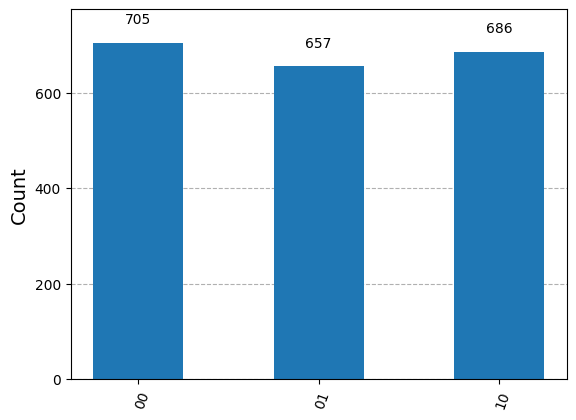

In [17]:
def simple_prog(register, T=np.pi/2):
    program = (
        register
        .rydberg.rabi.amplitude.uniform.piecewise_constant( # Omega = lambda t: 15
            durations=[T],
            values=[15]
        )
        .rydberg.rabi.phase.uniform.piecewise_constant( # phi = lambda t: 0
            durations=[T],
            values=[0]
        )
        .rydberg.detuning.uniform.piecewise_constant( # Delta = lambda t: 0
            durations=[T],
            values=[0]
        )
    )
    return program

register = start.add_position([(0,0), (5,0)])  # (um)
results = simple_prog(register).bloqade.python().run(2048)
report = results.report()
plot_histogram(invert_keys(report.counts()))

### Rydberg Blockade

The **Rydberg Blockade** is a phenomenon where an excited state of one qubit prevents another nearby qubit from being excited, thus producing the effect of entanglement. In the example above, we "rarely" observed the outcome $\ket{11}$ due to the blockade mechanism. Mathematically, we saw that the distance between the atoms affected the Hamiltonian through the interaction term. The **blockade radius** is defined as

$$
R_\text{blockade} = \left( \frac{C_6}{\Omega} \right)^{1/6} \,.
$$

When the distance between two atoms is less than $R_\text{blockade}$, the excited state of one atom will block the other from getting excited. Outside of $R_\text{blockade}$, each atom will have less and less of an effect.

In [18]:
def bloqade_radius(Omega):
    return (RB_C6 / Omega) ** (1/6)

print("Bloqade radius", bloqade_radius(Omega), "um")

Bloqade radius 8.439639489080086 um


##### Outside of blockade radius

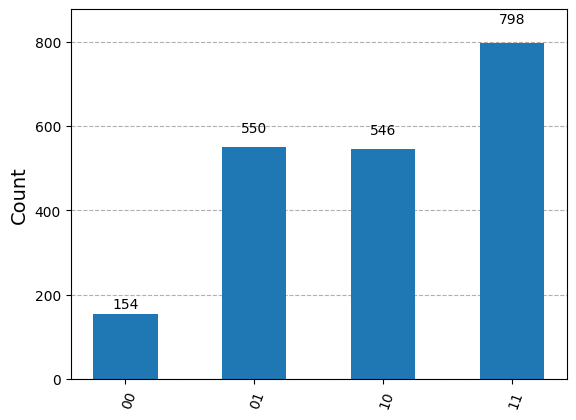

In [19]:
register = start.add_position([(0,0), (8.7, 0)])  # (um)
results = simple_prog(register).bloqade.python().run(2048)
report = results.report()
plot_histogram(invert_keys(report.counts()))

##### Within blockade radius

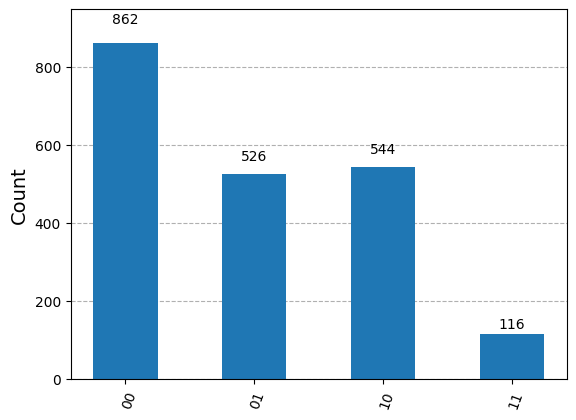

In [20]:
register = start.add_position([(0,0), (8.42, 0)])  # (um)
results = simple_prog(register).bloqade.python().run(2048)
report = results.report()
plot_histogram(invert_keys(report.counts()))

#### Qutip Simulation

As before, we can also use `qutip` to solve Schrödinger's equation.

In [21]:
T = np.pi/2
times = np.linspace(0, T, 100)
register = start.add_position([(0,0), (5,0)])  # (um)
H_rydberg = mk_H_Rydberg(2, Omega, phi, Delta, register)
z = basis(2, 0)
result = mesolve(Qobj(H_rydberg, dims=[[2, 2], [2, 2]]), tensor(z, z), times, [], [])
pretty(result.final_state)

1 0


<IPython.core.display.Latex object>

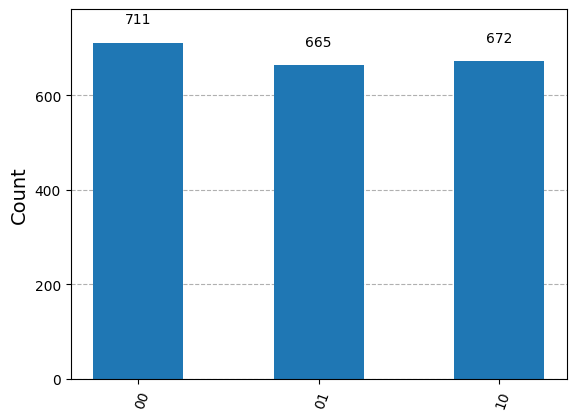

In [22]:
plot_histogram(histogram_final_state(result.final_state.full()))

## Summary

1. We introduced neutral atom quantum computing based on Rydberg atoms.
2. We introduced the Rydberg Hamiltonian and gave a few examples.
3. We examined the Rydberg Blockade mechanism which enables nearby qubits to interact with each other.

## References

[1] [Rydberg Hamiltonian](https://queracomputing.github.io/Bloqade.jl/dev/hamiltonians/#Hamiltonians)

[2] [Rydberg Blockade](https://queracomputing.github.io/Bloqade.jl/dev/tutorials/1.blockade/main/)

[3] [https://bloqade.quera.com/0.15.14/](https://bloqade.quera.com/0.15.14/)

[4] [https://www.quera.com/glossary/rubidium](https://www.quera.com/glossary/rubidium)